This is the first project of the Greedy-tech NLP Camp. Our goal is to understand each part of the NLP task and build a retrieval-based QA system.
The organization of this project is as follows:
Part 1: build a word segmentation tool with the enumeration method
part 2: apply the Viterbi algorithm to decrease the time complexity
part 3: understand the dataset, which involves the question-answer pair
part 4: text preprocessing
part 5: word representation with tf-idf method
part 6: find the top 5 answers to a testing question by comparing the testing question's cosine similarity with the questions in the data set
part 7: apply the inverted index to decrease the time complexity
part 8: replace the tf-idf word representation with the word2vec method


part 1: build a word segmentation tool with the enumeration method 
The given data includes:
1) one Chinese dictionary, dic.xlsx
2) part of the words' probability. For other words' probability, if the word exists in the dictionary, then the probability is 0.00001, otherwise 0.

In [1]:
# use set to store the dictionary and check the given probability
import pandas as pd
dic_words = pd.read_excel('data\dic.xlsx',header=None)   
dic_set = set(dic_words[0])
print('羊肚子' in dic_set)

word_prob = {"北京":0.03,"的":0.08,"天":0.005,"气":0.005,"天气":0.06,"真":0.04,"好":0.05,"真好":0.04,"啊":0.01,"真好啊":0.02, 
             "今":0.01,"今天":0.07,"课程":0.06,"内容":0.06,"有":0.05,"很":0.03,"很有":0.04,"意思":0.06,"有意思":0.005,"课":0.01,
             "程":0.005,"经常":0.08,"意见":0.08,"意":0.01,"见":0.005,"有意见":0.02,"分歧":0.04,"分":0.02, "歧":0.005}

print (sum(word_prob.values()))

True
1.0000000000000002


In [6]:
# build a naive word segmentation tool and check the results
import math
def word_segment_naive(input_str):
    """
    input chinese words and output its best segmentation.
    use dfs to do exploration search
    """
    best_score = 1e10       
    segments = helper(input_str)
    for st in segments:
        score = 0
        for each in st:
            score -= math.log(word_prob.get(each,0.00001))
        if score < best_score:
            best_score = score
            best_segment = st  

    return best_segment

In [4]:
def helper(input_str):
    if(len(input_str) == 0):
        return[[]]
    else:
        res = []
        for i in range(1,len(input_str)+1):
            if(input_str[:i] in dic_set):
                tmp = helper(input_str[i:])
                for j in tmp:
                    res.append([input_str[:i]] + j)
        return res

In [5]:
helper("今天天气好")

[['今', '天', '天', '气', '好'],
 ['今', '天', '天气', '好'],
 ['今', '天天', '气', '好'],
 ['今天', '天', '气', '好'],
 ['今天', '天气', '好']]

In [7]:
#test
print(word_segment_naive("今天天气好"))
print(word_segment_naive("今天的课程内容很有意思"))
print(word_segment_naive("经常有意见分歧"))

['今天', '天气', '好']
['今天', '的', '课程', '内容', '很', '有意思']
['经常', '有', '意见', '分歧']


time complexity: O(2^n), space complexity: O(2^n)

part 2: apply the Viterbi algorithm to decrease the time complexity


In [15]:
word_prob.update(
{word:0.00001 for word in dic_set if word not in word_prob.keys()}
)
word_score = {word: -math.log(word_prob[word]) for word in word_prob.keys()}

In [18]:
import collections
def get_graph(input_str):
    graph = collections.OrderedDict()
    for i in range(len(input_str) + 1):
        if i not in graph: 
            graph[i] = {}
        for j in range(i):
            if input_str[j:i] in word_score.keys():
                graph[i][j] = word_score[input_str[j:i]]
    return graph

In [19]:
print(get_graph("今天天气好"))

OrderedDict([(0, {}), (1, {0: 4.605170185988091}), (2, {0: 2.659260036932778, 1: 5.298317366548036}), (3, {1: 11.512925464970229, 2: 5.298317366548036}), (4, {2: 2.8134107167600364, 3: 5.298317366548036}), (5, {4: 2.995732273553991})])


In [34]:
def get_best_path(graph):
    score = {0:0}
    path = {}
    for i in graph.keys():
        if graph[i]:
            for j in graph[i].keys():
                if i not in score.keys() or score[i] > graph[i][j] + score[j]:
                    score[i] = graph[i][j] + score[j]
                    path[i] = j
    return path

In [35]:
graph = get_graph("今天天气好")
print(get_best_path(graph))

{1: 0, 2: 0, 3: 2, 4: 2, 5: 4}


In [36]:
def path_to_segment(path, input_str):
    """
    input chinese string and output the best segmentation
    build the graph first and then use the viterbi to solve it
    """
    segment = []
    i = len(input_str)
    while i > 0:
        segment = [input_str[path[i] : i]] + segment
        i = path[i]
    #segment.reverse()
    return segment

In [37]:
graph = get_graph("今天天气好")
path = get_best_path(graph)
print(path_to_segment(path, "今天天气好"))

['今天', '天气', '好']


In [42]:
def word_segment_viterbi(input_str):
    graph = get_graph(input_str)
    path = get_best_path(graph)
    segment = path_to_segment(path, input_str)
    return segment                 


In [43]:
#test
print(word_segment_viterbi("北京的天气真好啊"))
print(word_segment_viterbi("今天的课程内容很有意思"))
print(word_segment_viterbi("经常有意见分歧"))

['北京', '的', '天气', '真好啊']
['今天', '的', '课程', '内容', '很有', '意思']
['经常', '有意见', '分歧']


time complexity: O(n^2), space complexity: O(n^2)

Potential further improvement:
1) the current probability is calculated based on the collected documents. We can consider more data to get more accurate probability
2) one-order markov is nor precise
3) it can not deal with polysemy
4) if the words do not exist in the dictionary, these words can not be segmented correctly.

part 3:understand the dataset, which involves the question-answer pair
From this part, we start build our retrieval-based QA system.
The given data includes:
1) dev-v2.0.json file includes the question-answer pair

In [3]:
import json
from collections import defaultdict
from matplotlib import pyplot as plt
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import heapq
import numpy as np
import re
from scipy.spatial.distance import cosine as cosdist
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
qa_corpus_path = './data/train-v2.0.json'
glove_path = "./data/glove.6B.100d.txt"

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dwang\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dwang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# read file and plot the data
def read_corpus():
    with open(qa_corpus_path, 'r', encoding='utf-8') as fp:
        json_corpus = json.load(fp)['data']
    qlist = []; alist = []
    for item in json_corpus:
        for para in item["paragraphs"]:
            for qa in para["qas"]:
                qlist.append(qa["question"])
                try:
                    alist.append(qa["answers"][0]["text"])
                except IndexError:
                    qlist.pop()
                
    assert len(qlist) == len(alist) 
    return qlist, alist
    

In [73]:
qlist, alist = read_corpus()
qlist[0]

'When did Beyonce start becoming popular?'

In [6]:
alist[0]

'in the late 1990s'

In [10]:
def get_dict(textlist):
    """
    input sentence list, and output word dict {word, #counts}
    """
    word_dict = defaultdict(lambda:0)
    for text in textlist:
        for token in text.split(" "):
            word_dict[token] += 1
    word_dict = sorted(word_dict.items(), key=lambda item:item[1], reverse=True)
    return dict(word_dict)
            

In [14]:
def get_topk(n, word_dict):
    """
    return the most frequent n words from the dict
    """
    res=[]
    for word, freq in word_dict.items():
        res.append("{}({})".format(word,freq))
        n-=1;
        if n == 0:
            return res 

In [74]:
# data statistics analysis
q_dict = get_dict(qlist)
word_total_q = sum(q_dict.values())
n_distinct_words_q = len(q_dict)
print("There are {} words and {} distinct tokens".format(word_total_q, n_distinct_words_q))

There are 903411 words and 63780 distinct tokens


<BarContainer object of 10000 artists>

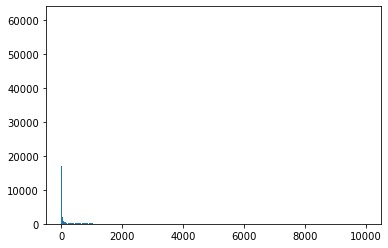

In [18]:
plt.bar(np.arange(10000), list(q_dict.values())[:10000])

<BarContainer object of 10000 artists>

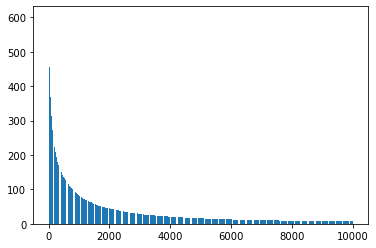

In [19]:
plt.bar(np.arange(10000), list(q_dict.values())[100:10100])

The above figure satisfies the zipf's law.

part 4: text preprocessing

In [75]:
#preprocessing
"""
1. we use the lemmatizer instead of the stemming method. Because stemming method
is build based on rules while lemmatizer can return the original words.
eg:
leaves---stemming---leav , usually the returned is not a word
leaves---lemmatizer---leaf
2. we use #num to replace all tnumbers in the corpus
3. transfer all words to starting with the small letters.
4. filter the words with stopwords provided by nltk
5. remove meanless symbols
6. remove low frequency words
7. filter the most frequent and lowest frequent words
"""
class TextNormalizer:
    def __init__(self, stopwords_set, filter_vocab, re_cleaners):
        self.lemmatizer = WordNetLemmatizer()
        self.filter_vocab = filter_vocab
        self.stopwords = stopwords_set
        self.re_cleaners = re_cleaners
    def get_wordnet_pos(self, treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return ''
    def normalize_texts(self, text_list):
        return [self.normalize_text(text) for text in text_list]
    def normalize_text(self, text):
        for re_pattern in self.re_cleaners:
            text = re.sub(re_pattern, " ", text)
        pos_tokens = pos_tag(word_tokenize(text))
        lemmatized = []
        for w, pos in pos_tokens:
            if not w or w in self.stopwords or w in self.filter_vocab: continue
            if pos == 'CD':
                lemmatized.append("#NUM")
                continue
            wn_pos = self.get_wordnet_pos(pos)
            if wn_pos:
                lemmatized.append(self.lemmatizer.lemmatize(w, pos=wn_pos))
            else:
                lemmatized.append(self.lemmatizer.lemmatize(w))
        return " ".join(lemmatized).lower()

In [76]:
stwset = set(stopwords.words('english'))
stwset.update({'-s','-ly','</s>','\'s','\'\'', '\''})
threshold_lower = 1
threshold_upper = 1e4
re_pats = [r'[?|!|\'|"#]',r'[.|,|)|(|\|/]']
filter_words = {w for w, freq in q_dict.items() if freq <= threshold_lower or freq >= threshold_upper}
text_normalizer = TextNormalizer(stwset, filter_words, re_pats)
qlist = text_normalizer.normalize_texts(qlist)

1.here I choose the threshold to be 1. Because at least 50% of the words appear once. Many odd experssions, symbols and strange characters appear once.
2.inorder to keep the readablity of the answer, I do not normalize the answer list here.

In [ ]:
"""
from nltk.stem import PorterStemmer
ps = PorterStemmer()
for word in word_tokenize(text):
    word = ps.stem(word.lower())
"""


part 5: word representation with tf-idf method

In [77]:
# word expression with tfidf
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(qlist)
"""
tf-idf adv: easy, fast, understandable
disadv: can not consider the context, position, pos and etc
sometimes the key words appear one or two times
X is stored in sparse matrix form
"""

'\ntf-idf adv: easy, fast, understandable\ndisadv: can not consider the context, position, pos and etc\nsometimes the key words appear one or two times\nX is stored in sparse matrix form\n'

In [78]:
# check the sparsity
sparsity = np.divide(np.prod(X.shape) - len(X.nonzero()), np.prod(X.shape))
sparsity

0.9999999988142327

part 6: find the top 5 answers to a testing question by comparing the testing question's cosine similarity with the questions in the data set

In [79]:
# find the top5 answer
def top5results(input_q, K=5):
    """
    input strings, return top5 strings
    use cos to measure the similarity
    use pq to find kth largest
    """
    if not input_q or type(input_q)!= type(""):
        print("input error")
        return
    input_q = text_normalizer.normalize_text(input_q)
    q_vec = vectorizer.transform([input_q]).todense()
    top_k_indices, top_idx = [], []
    for i in range(X.shape[0]):
        similarity = 1 - cosdist(X[i,:].todense(), q_vec)
        similarity = 0 if np.isnan(similarity) else similarity
        if len(top_k_indices) == K:
            heapq.heappushpop(top_k_indices,(similarity, i))
        else:
            heapq.heappush(top_k_indices, (similarity, i))
    top_idxs = sorted(top_k_indices, reverse=True)
    _, top_idxs = zip(*top_idxs[::-1])
    return [alist[id] for id in top_idxs]

In [80]:
# test
print(top5results("who is the president of THE UNITED STATES NOW???"))

C:\Users\dwang\anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
C:\Users\dwang\anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
C:\Users\dwang\anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
C:\Users\dwang\anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
C:\Users\dwang\anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
C:\Users\dwang\anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.

C:\Users\dwang\anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
C:\Users\dwang\anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
C:\Users\dwang\anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
C:\Users\dwang\anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
C:\Users\dwang\anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
C:\Users\dwang\anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.

['Andrew Jackson', 'January 20, 1953', 'George Washington', 'President Johnson', 'President Franklin D. Roosevelt']


complexity analysis
time O(ND) 
N refers to the number of questions in the data set D refers to the size of the dictionary We calculate the cosin-similarity with the D time
complexity Comparing the querried question with all N questions in data set is in time complexity N
space O(1)

issues:
1. the answer is constrainted by our question-answer pairs
2. the word "now" has no use
3. the time complexity is too high. If the size of the question-answer paris is too large, it cost too much time to calculate cos similarity with each pair.

part 7: apply the inverted list to decrease the time complexity.    
use inverted list to find candidates first inorder to save the cos similarity time

In [81]:
def create_inverted_idx(text_list):
    """
    output inverted idx dict
    """
    invidx = defaultdict(lambda:set())
    for i, text in enumerate(text_list):
        for token in text.split(" "):
            if not token: continue
            invidx[token].add(i)
    return invidx
            

In [82]:
def get_candidate_docs(invidx, query):
    """
    find the intersection of document sets of the query 
    tokens and the inverted dict
    """
    candidate_ids = set()
    for token in query.split(" "):
        docs = invidx.get(token, set())
        candidate_ids = candidate_ids.intersection(docs)
    if candidate_ids:
        return list(candidate_ids)
    
    for token in query.split(" "):
        candidate_ids = candidate_ids.union(invidx.get(token, set()))
    if candidate_ids:
        return list(candidate_ids)
    return None

In [83]:
inverted_idx = create_inverted_idx(qlist)
def top5results_invidx(input_q, K=5):
    """
    similar to the above one, except we use inverted list to
    find the candidate set first.
    """
    if not input_q or type(input_q)!= type(""):
        print("input error")
        return
    input_q = text_normalizer.normalize_text(input_q)
    candidate_docs = get_candidate_docs(inverted_idx, input_q)
    if not candidate_docs:
        print("no answer error")
        return
    q_vec = vectorizer.transform([input_q]).todense()
    top_k_indices, top_idx = [], []
    for i in candidate_docs:
        doc_vec = X[i,:].todense()
        similarity = 1 - cosdist(doc_vec, q_vec)
        similarity = 0 if np.isnan(similarity) else similarity
        if len(top_k_indices) == K:
            heapq.heappushpop(top_k_indices,(similarity, i))
        else:
            heapq.heappush(top_k_indices, (similarity, i))
    top_idxs = sorted(top_k_indices, reverse=True)
    _, top_idxs = zip(*top_idxs[::-1])
    return [alist[id] for id in top_idxs]

In [84]:
# test
print(top5results_invidx("who is the president of THE UNITED STATES NOW???"))

['Andrew Jackson', 'January 20, 1953', 'George Washington', 'President Johnson', 'President Franklin D. Roosevelt']


complexity analysis time O(N_d * D)   N_d is the size of the largest set in the inverted list.



step 8, use word2vec.                        
In the above part, we use the bag-of-words model. But this model can not consider the similarity between words and the representation vector is sparse. In the following part, we use the word2vec model with glove.6B.100.

In [98]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import numpy as np
_ = glove2word2vec('data/glove.6B.100d.txt','data/glove2word2vec.6B.100d.txt')
model = KeyedVectors.load_word2vec_format('data/glove2word2vec.6B.100d.txt')

def word2vec_get(seg):
    """
    get wordVec of seg with glove
    """
    vector = np.zeros([1,100])
    size = len(seg)
    for word in seg:
        try:
            vector += model.wv[word]
        except KeyError:
            size -= 1
    vector /= size
    vector_norm = np.linalg.norm(vector / size,axis=1,keepdims=True)
    return vector / vector_norm



In [99]:
X = np.zeros([len(qlist), 100])
for cur in range(X.shape[0]):
    X[cur] = word2vec_get(qlist[cur])

<ipython-input-98-329ac26b571f>:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vector += model.wv[word]


In [100]:
def top5results_emb(input_q, K=5):
    """
    similar to the above ones, except that we use word2vec
    """
    if not input_q or type(input_q)!= type(""):
        print("input error")
        return
    input_q = text_normalizer.normalize_text(input_q)
    candidate_docs = get_candidate_docs(inverted_idx, input_q)
    if not candidate_docs:
        print("no answer error")
        return
    q_vec = word2vec_get(input_q)
    top_k_indices, top_idx = [], []
    for i in candidate_docs:
        doc_vec = X[i,:]
        similarity = 1 - cosdist(doc_vec, q_vec)
        similarity = 0 if np.isnan(similarity) else similarity
        if len(top_k_indices) == K:
            heapq.heappushpop(top_k_indices,(similarity, i))
        else:
            heapq.heappush(top_k_indices, (similarity, i))
    top_idxs = sorted(top_k_indices, reverse=True)
    _, top_idxs = zip(*top_idxs[::-1])
    return [alist[id] for id in top_idxs]

In [101]:
# test
print(top5results_emb("who is the president of THE UNITED STATES NOW???"))

['the encyclical', 'George Washington', 'the colonies first rejected the authority of the Parliament to govern them without representation', '1985', 'Andrew Jackson']


<ipython-input-98-329ac26b571f>:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vector += model.wv[word]
